# Nesting MicroHH in ERA5

This notebook contains documentation and examples for nesting MicroHH with open boundary conditions in ERA5.

Nesting LES-in-LES is documented separately in `TODO.ipynb`.

In [1]:
#%matplotlib ipympl

# Standard library
import logging

# Third-party.
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import ls2d
import cartopy.crs as ccrs
import nest_asyncio

# Local library
from microhhpy.spatial import Domain, plot_domains, Vertical_grid_2nd
from microhhpy.openbc import create_era5_input
from microhhpy.thermo import Basestate_moist

TF = np.float64

# Needed to use asyncio with Jupyter notebooks.``
nest_asyncio.apply()

# Set output level `microhhpy`.
logger = logging.getLogger("microhhpy")
logger.setLevel(logging.INFO)   # or DEBUG

## ERA5 data

For now, we use (LS)²D to download and read the ERA5 data. This can be simplified later, as we only need a few 3D fields from ERA5, and do not use the large-scale forcings typically required for a doubly periodic LES.

In [2]:
settings = {
    'start_date'  : datetime(year=2022, month=4, day=1, hour=8),
    'end_date'    : datetime(year=2022, month=4, day=1, hour=20),
    'central_lon' : 4.8,
    'central_lat' : 53,
    'area_size'   : 5,
    'case_name'   : 'slocs_rf',
    'era5_path'   : '/home/scratch1/bart/LS2D_ERA5/',
    'era5_expver' : 1,
    'cdsapirc'    : '/home/bart/.cdsapirc_ads'
    }

era5 = ls2d.Read_era5(settings)
era5.calculate_forcings(n_av=3, method='2nd')

Reading ERA5 from 2022-04-01 08:00:00 to 2022-04-01 20:00:00 [19-06: 13:50]
Calculating large-scale forcings [19-06: 13:50]
 - Using nearest lat/lon = 52.97/4.92 (requested = 53.00/4.80), distance ~= 8.7 km
 - Averaging ERA5 over a 1.75°×1.75° spatial area.


## Spatial projection

To nest LES in ERA5, a transformation is needed from the LES grid (in meters) to geographic coordinates (latitude / longitude in degrees).

The `Domain()` class provides a simple way to define the domain. The spatial transformation is performed using `pyproj`, based on the `proj_str` definition.

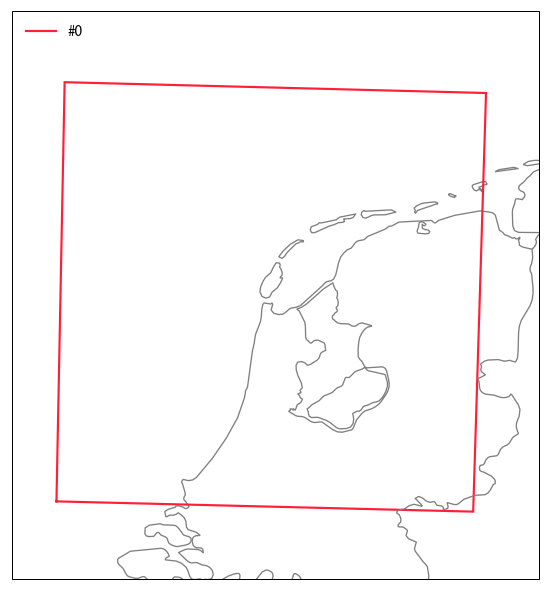

In [3]:
dom0 = Domain(
    xsize=256_000,
    ysize=256_000,
    itot=128,
    jtot=128,
    n_ghost=3,
    n_sponge=4,
    lon=4.8,
    lat=53,
    anchor='center',
    proj_str='+proj=utm +zone=31 +ellps=intl +towgs84=-87,-98,-121,0,0,0,0 +units=m +no_defs +type=crs'
    )

plot_domains([dom0], use_projection=True)

Note that each `Domain` instance includes two projections: one with ghost cells and one without. The version with ghost cells is needed for generating the lateral boundary conditions.

The padded projection actually includes `nghost + 1` ghost cells. The extra cells are needed to create divergence free fields in the east- and north-most ghost cells.

In [4]:
print(dom0.proj.itot, dom0.proj_pad.itot)

128 136


Coordinate pairs are available for each grid point location `(u, v, scalar)`:

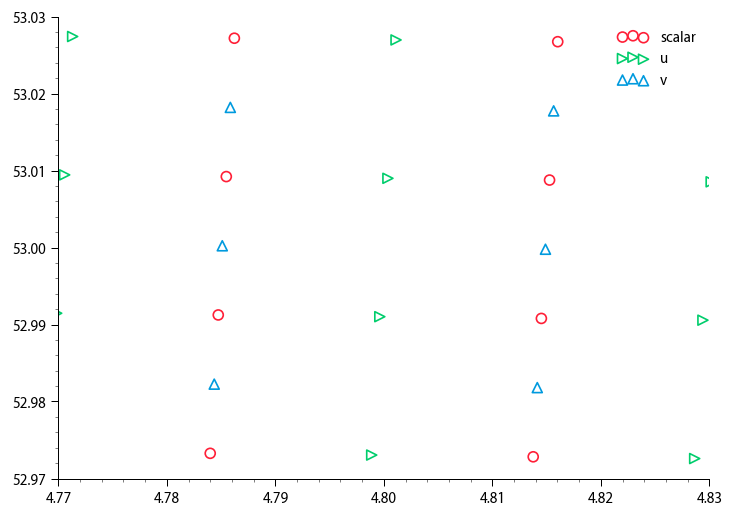

In [5]:
plt.figure()

plt.scatter(dom0.proj.lon,   dom0.proj.lat,   marker='o', facecolor='none', edgecolor='C0', label='scalar')
plt.scatter(dom0.proj.lon_u, dom0.proj.lat_u, marker='>', facecolor='none', edgecolor='C1', label='u')
plt.scatter(dom0.proj.lon_v, dom0.proj.lat_v, marker='^', facecolor='none', edgecolor='C2', label='v')

plt.xlim(dom0.proj.central_lon-0.03, dom0.proj.central_lon+0.03)
plt.ylim(dom0.proj.central_lat-0.03, dom0.proj.central_lat+0.03)

plt.legend()

## Vertical grid

In [6]:
zsize = 3200
ktot = 128
dz = zsize / ktot
z = np.arange(dz/2, zsize, dz)

## Basestate density

Interpolate mean ERA5 fields to LES grid as basis for the LES basestate density. Again, this has to _perfectly_ match the basestate density used by MicroHH.

In [7]:
les_input = era5.get_les_input(z)

bs = Basestate_moist(
    les_input['thl'][0,:].values,
    les_input['qt'][0,:].values,
    float(les_input['ps'][0].values),
    z,
    zsize,
    remove_ghost=True,
    dtype=TF)

<div class="alert alert-block alert-info">NOTE: using an incorrect vertical grid definition or a base state density that doesn't match the one in MicroHH is one of the easiest ways to mess up the initialization. If your MicroHH simulations are not divergence-free at `t==0`, this should be the first thing to check.</div>

## Initial conditions

The initial conditions are (not so...) simply the 3D ERA5 fields tri-linearly interpolated to the LES grid.

To reduce the blocky structures that result from interpolating coarse ERA5 data, a Gaussian filter with standard deviation `sigma_h` is applied after interpolation.

### Momentum & divergence
The momentum fields require special treatment because they must be divergence-free. To achieve this, the `(u, v)` velocity components are corrected such that:

1. The resulting fields are divergence-free, and:
2. The domain-mean vertical velocity in LES matches that from ERA5.

Note that we correct the horizontal velocities as `u,v >> w`, and correcting `w` can cause a significant mismatch in subsidence between LES and ERA5.

### Output

The initial conditions are written directly as binary input files (e.g. `u.0000000`) for MicroHH in the specified `output_dir`. By setting a `name_suffix`, the files can optionally be written with a custom name, such as `u_some_name.0000000`. This allows you to overwrite the homogeneous 3D restart files generated during the `init` phase of MicroHH with the fields derived from ERA5.

<div class="alert alert-block alert-info">NOTE: When using (LS)²D data, be sure to use `wls` (and not `w`) for the vertical velocity!</div>

In [8]:
fields_era = {
    'u': era5.u[:,:,:,:],
    'v': era5.v[:,:,:,:],
    'w': era5.wls[:,:,:,:],
    'thl': era5.thl[:,:,:,:],
    'qt': era5.qt[:,:,:,:],
}

z_era = era5.z[:,:,:,:]
time_era = era5.time_sec

# Gaussian filter size (m) of filter after interpolation.
sigma_h = 10_000

create_era5_input(
    fields_era,
    era5.lons.data,   # Strip off array masks.
    era5.lats.data,
    z_era,
    time_era,
    z,
    zsize,
    bs.rho,
    bs.rhoh,
    dom0,
    sigma_h,
    name_suffix='era5',
    output_dir='.',
    ntasks=16,
    dtype=TF)

[2025/06/19 13:51:04] [microhhpy] [INFO] Creating MicroHH input from ERA5 data in ..'
[2025/06/19 13:51:05] [microhhpy] [INFO] Using Gaussian filter with sigma = 5 grid cells'
[2025/06/19 13:51:07] [microhhpy] [INFO] Created scalar input from ERA5 in 0:00:02.619189.'
[2025/06/19 13:51:11] [microhhpy] [INFO] Created momentum input from ERA5 in 0:00:03.524204.'
